<h1 style="text-align: center;">MMM - Gradient Boosting</h1>

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['font.size'] = 18
import seaborn as sns
sns.set_style("whitegrid")

from plotnine import *

import plotly.io as pio
pio.renderers.default = 'notebook' # or 'colab' or 'jupyterlab'

In [2]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [80]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
lgb_params = {"verbose": -1}
import shap
shap.initjs()

In [8]:
from prophet import Prophet

In [9]:
import optuna as opt
from functools import partial

In [11]:
df

,Date,TV,Digital,OOH,SEO,Social_Media,Economic_Index,Vacances,Revenu
0,2022-01-02,8745.40119,7377.08438,1177.45520,1058.98960,3473.01909,100.41343,0,16408.75860
1,2022-01-09,14507.14306,8092.95692,7738.53890,2908.05635,2475.65456,101.97680,0,18039.45786
2,2022-01-16,12319.93942,3901.10035,6851.86084,530.38619,2850.13886,99.42621,0,19247.96652
3,2022-01-23,10986.58484,7825.73079,5871.81944,2924.69707,3989.88375,99.05535,0,17500.95351
4,2022-01-30,6560.18640,4942.26506,3862.67061,607.89978,1146.73281,98.62128,0,17243.10712
...,...,...,...,...,...,...,...,...,...
151,2024-11-24,7395.61891,4583.65178,5083.58136,2370.64923,1599.66971,117.73238,0,18687.12240
152,2024-12-01,6448.94872,8361.48956,7735.20784,961.30255,1917.00558,115.69332,0,18689.17945
153,2024-12-08,9894.52760,4166.65801,3624.09406,1023.37331,3889.01027,115.48484,0,19934.07810
154,2024-12-15,14856.50454,5511.77137,2999.98460,1426.18026,3880.14615,114.54164,0,18610.12856


## Helper Functions

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed
    
    
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        if slope_s < 0 or half_saturation_k < 0:
            raise ValueError("slope_s and half_saturation_k must be non-negative")
                             
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        self.epsilon = 1e-9  # small constant value to avoid division by zero
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / (X**self.slope_s + self.epsilon))**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / (x_point**self.slope_s + self.epsilon))**-1
            

## Data

In [102]:
# =========================================== Dummy Dataset for the example ===================================================

# Set random seed for reproducibility
np.random.seed(42)

# ========= 1. Create a weekly date series over 3 years ========= #
start_date = '2022-01-01'
n_weeks = 3 * 52  # Approximately 156 weeks
dates = pd.date_range(start=start_date, periods=n_weeks, freq='W')

# ========= 2. Define variables and generate data ========= #
# Define lists of variables by category
media_channels = ['TV', 'Digital', 'OOH']           # Paid media channels
organic_channels = ['SEO', 'Social_Media']          # Organic channels
control_features = ['Economic_Index', 'Vacances']   # Contextual control variables

# Create an initial DataFrame with the Date column
df = pd.DataFrame({'Date': dates})
n = len(df)

# --- Generate marketing spend for each channel --- #
# For paid media channels, simulate weekly budgets
df['TV'] = np.random.uniform(5000, 15000, n)
df['Digital'] = np.random.uniform(2000, 10000, n)
df['OOH'] = np.random.uniform(1000, 8000, n)

# For organic channels, simulate investments (e.g., SEO, social media, etc.)
df['SEO'] = np.random.uniform(500, 3000, n)
df['Social_Media'] = np.random.uniform(1000, 5000, n)

# --- Contextual control variables --- #
# Economic_Index: Simulate an economic index with a slight linear trend and some noise
df['Economic_Index'] = 100 + 0.1 * np.arange(n) + np.random.normal(0, 1, n)

# Vacances: Binary indicator for whether the week falls within a vacation period
# Here, we consider "vacation" weeks to be those in July or August.
df['Vacances'] = df['Date'].dt.month.isin([7, 8]).astype(int)

# ========= 3. Create the target variable "Revenue" ========= #
# Define a simple linear model linking expenses and control variables to revenue
# The coefficients are arbitrarily chosen for this simulation
intercept = 5000
coef_tv = 0.05
coef_digital = 0.1
coef_ooh = 0.03
coef_seo = 0.2
coef_social = 0.15
coef_economic = 100
coef_vacances = 2000

# Compute simulated revenue with added random noise (std dev = 1000)
df['Revenu'] = (
    intercept +
    coef_tv * df['TV'] +
    coef_digital * df['Digital'] +
    coef_ooh * df['OOH'] +
    coef_seo * df['SEO'] +
    coef_social * df['Social_Media'] +
    coef_economic * df['Economic_Index'] +
    coef_vacances * df['Vacances'] +
    np.random.normal(0, 1000, n)
)

# ========= 4. Display and summary ========= #
print("Preview of the generated dataset:")
print(df.head())

# Define the target variable and the complete list of features
target = "Revenu"
media_channels_list = media_channels
organic_channels_list = organic_channels
control_features_list = control_features
features = control_features_list + media_channels_list + organic_channels_list

print("\nVariable categorization:")
print("target =", target)
print("media_channels =", media_channels_list)
print("organic_channels =", organic_channels_list)
print("control_features =", control_features_list)
print("features =", features)

# (Optional) Save the dataset to a CSV file
# df.to_csv("marketing_mix_dataset.csv", index=False)

Preview of the generated dataset:
        Date          TV    Digital        OOH        SEO  Social_Media  \
0 2022-01-02  8745.40119 7377.08438 1177.45520 1058.98960    3473.01909   
1 2022-01-09 14507.14306 8092.95692 7738.53890 2908.05635    2475.65456   
2 2022-01-16 12319.93942 3901.10035 6851.86084  530.38619    2850.13886   
3 2022-01-23 10986.58484 7825.73079 5871.81944 2924.69707    3989.88375   
4 2022-01-30  6560.18640 4942.26506 3862.67061  607.89978    1146.73281   

   Economic_Index  Vacances      Revenu  
0       100.41343         0 16408.75860  
1       101.97680         0 18039.45786  
2        99.42621         0 19247.96652  
3        99.05535         0 17500.95351  
4        98.62128         0 17243.10712  

Variable categorization:
target = Revenu
media_channels = ['TV', 'Digital', 'OOH']
organic_channels = ['SEO', 'Social_Media']
control_features = ['Economic_Index', 'Vacances']
features = ['Economic_Index', 'Vacances', 'TV', 'Digital', 'OOH', 'SEO', 'Social_Media

In [13]:
# data = pd.read_csv("your_file.csv") or
data = df.copy()

In [14]:
prophet_data = data.rename(columns = {'Revenu': 'y', 'Date': 'ds'})

In [15]:
prophet = Prophet(weekly_seasonality=True)

In [16]:
prophet

In [17]:
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing


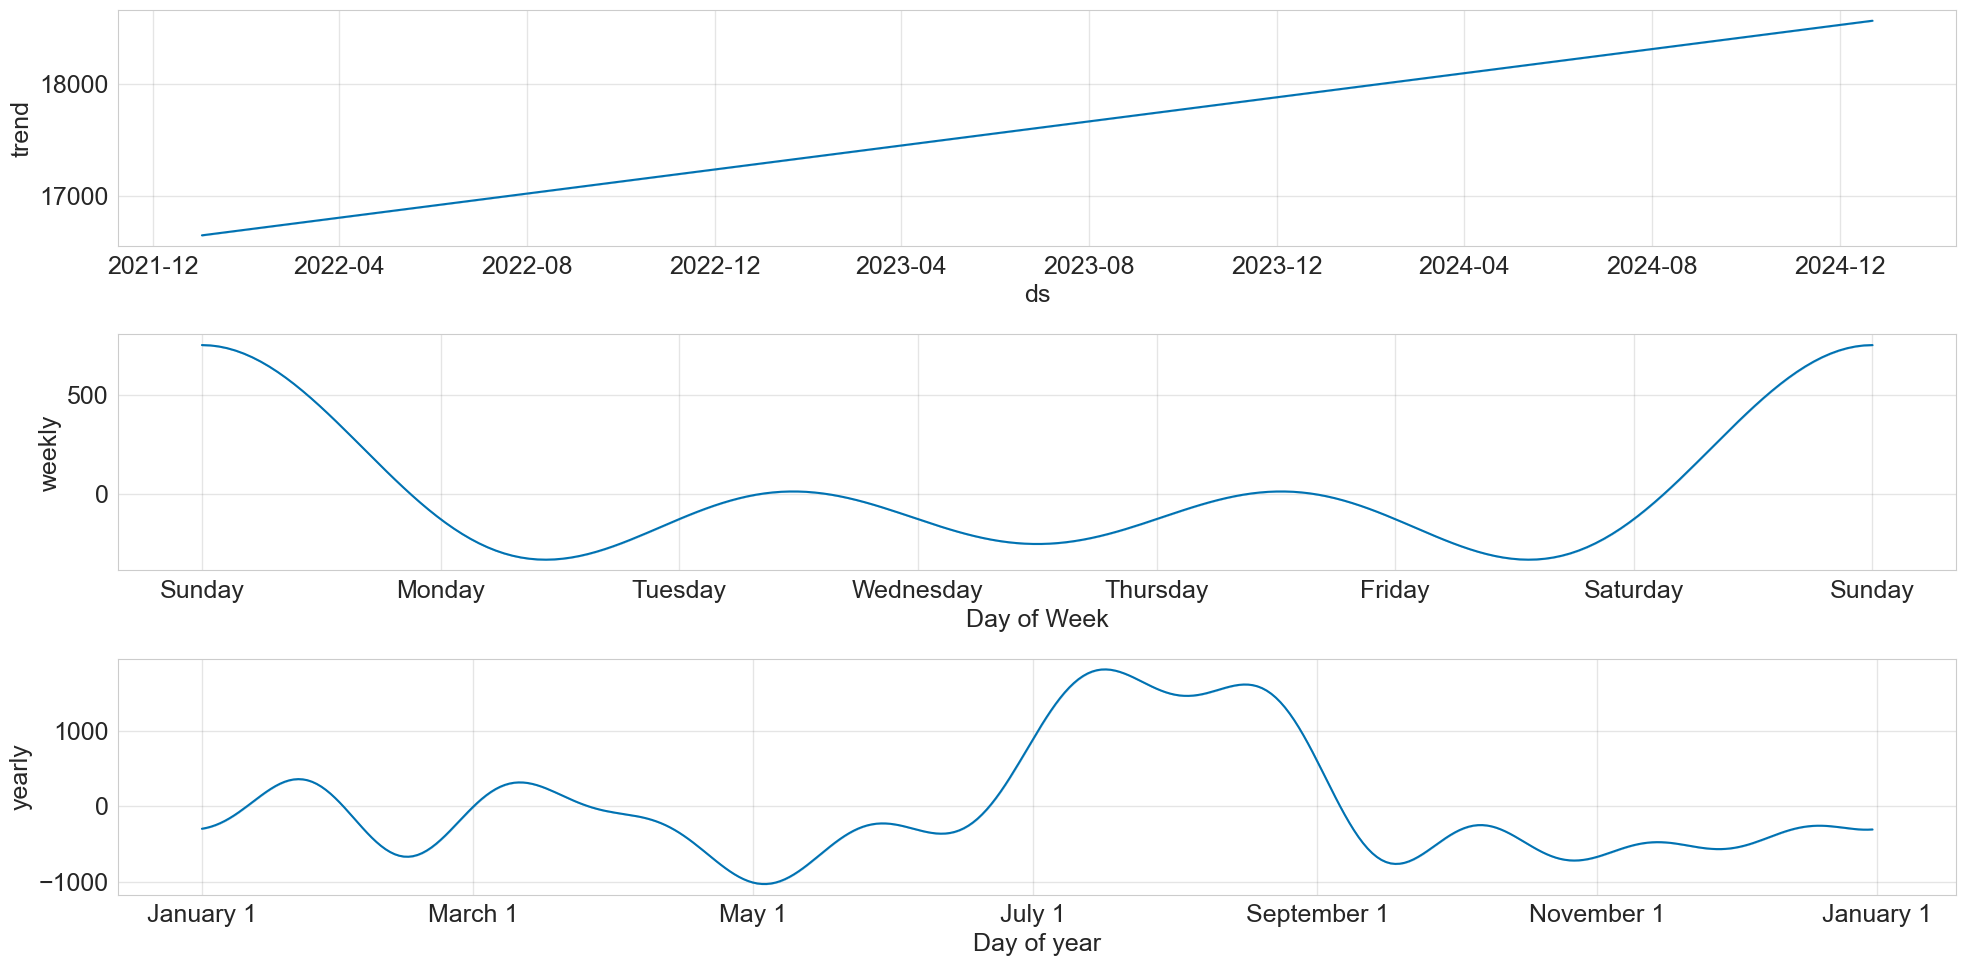

In [18]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [19]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["weekly"] = prophet_predict["weekly"]

In [20]:
final_data

,Date,TV,Digital,OOH,SEO,Social_Media,Economic_Index,Vacances,Revenu,trend,weekly
0,2022-01-02,8745.40119,7377.08438,1177.45520,1058.98960,3473.01909,100.41343,0,16408.75860,16646.17234,753.73045
1,2022-01-09,14507.14306,8092.95692,7738.53890,2908.05635,2475.65456,101.97680,0,18039.45786,16658.55084,753.73045
2,2022-01-16,12319.93942,3901.10035,6851.86084,530.38619,2850.13886,99.42621,0,19247.96652,16670.92934,753.73045
3,2022-01-23,10986.58484,7825.73079,5871.81944,2924.69707,3989.88375,99.05535,0,17500.95351,16683.30784,753.73045
4,2022-01-30,6560.18640,4942.26506,3862.67061,607.89978,1146.73281,98.62128,0,17243.10712,16695.68634,753.73045
...,...,...,...,...,...,...,...,...,...,...,...
151,2024-11-24,7395.61891,4583.65178,5083.58136,2370.64923,1599.66971,117.73238,0,18687.12240,18515.44635,753.73045
152,2024-12-01,6448.94872,8361.48956,7735.20784,961.30255,1917.00558,115.69332,0,18689.17945,18527.82626,753.73045
153,2024-12-08,9894.52760,4166.65801,3624.09406,1023.37331,3889.01027,115.48484,0,19934.07810,18540.20618,753.73045
154,2024-12-15,14856.50454,5511.77137,2999.98460,1426.18026,3880.14615,114.54164,0,18610.12856,18552.58610,753.73045


In [21]:
data = final_data.copy()

## Modeling Ridge Regression

In [22]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 hill_slopes_params, 
                 hill_half_saturations_params, 
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}
    hill_slopes = {}
    hill_half_saturations = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        hill_slope_param = f"{feature}_hill_slope"
        min_, max_ = hill_slopes_params[hill_slope_param]
        hill_slope = trial.suggest_float(f"hill_slope_{feature}", min_, max_)
        hill_slopes[feature] = hill_slope
        
        hill_half_saturation_param = f"{feature}_hill_half_saturation"
        min_, max_ = hill_half_saturations_params[hill_half_saturation_param]
        hill_half_saturation = trial.suggest_float(f"hill_half_saturation_{feature}", min_, max_)
        hill_half_saturations[feature] = hill_half_saturation
        
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        #hill saturation transformation
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_temp[feature] = temp_hill_saturation
        
        
    #Ridge parameters
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10000)
    scores = []
    
    #cross validation
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #params of Ridge Regression
        params = {"alpha": ridge_alpha}
        
        ridge = linear_model.Ridge(alpha = ridge_alpha, random_state=0)
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("hill_slopes", hill_slopes)
    trial.set_user_attr("hill_half_saturations", hill_half_saturations)
    
    
    #average of all scores    
    return np.mean(scores)

In [23]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    hill_slopes_params, 
                    hill_half_saturations_params, 
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")

    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    hill_slopes_params = hill_slopes_params, 
                                    hill_half_saturations_params = hill_half_saturations_params, 
                                    tscv = tscv, 
                                    )
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

### Features and parameters

In [24]:
target = "Revenu"
media_channels = ["TV", "Digital", "OOH"]
organic_channels = ["SEO", "Social_Media"]
control_features = ["Economic_Index", "Vacances"]
features = control_features + media_channels + organic_channels

tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

# --- Paramètres pour l'adstock (transformation des dépenses) ---
adstock_features_params = {}
adstock_features_params["TV_adstock"] = (0.3, 0.8)
adstock_features_params["Digital_adstock"] = (0.1, 0.4)
adstock_features_params["OOH_adstock"] = (0.2, 0.5)
adstock_features_params["SEO_adstock"] = (0.1, 0.4)
adstock_features_params["Social_Media_adstock"] = (0.1, 0.4)

# --- Paramètres pour la transformation Hill (pente) ---
hill_slopes_params = {}
hill_slopes_params["TV_hill_slope"] = (0.1, 5.0)
hill_slopes_params["Digital_hill_slope"] = (0.1, 5.0)
hill_slopes_params["OOH_hill_slope"] = (0.1, 5.0)
hill_slopes_params["SEO_hill_slope"] = (0.1, 5.0)
hill_slopes_params["Social_Media_hill_slope"] = (0.1, 5.0)

# --- Paramètres pour la transformation Hill (seuil de saturation) ---
hill_half_saturations_params = {}
hill_half_saturations_params["TV_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["Digital_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["OOH_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["SEO_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["Social_Media_hill_half_saturation"] = (0.1, 1.0)


OPTUNA_TRIALS = 1000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             hill_slopes_params = hill_slopes_params,
                             hill_half_saturations_params = hill_half_saturations_params,
                             tscv = tscv)

data size: 156
adstock features: ['TV', 'Digital', 'OOH', 'SEO', 'Social_Media']
features: ['Economic_Index', 'Vacances', 'TV', 'Digital', 'OOH', 'SEO', 'Social_Media']


C:\Users\Bens\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
np.mean(experiment.best_trial.user_attrs["scores"]), experiment.best_trial.user_attrs["scores"]

(798.1423824062226, [1045.9735420995428, 550.3112227129026])

In [26]:
#ridge regression param
experiment.best_trial.user_attrs["params"]

{'alpha': 1.3324189445936225}

In [27]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'TV': 0.6555938208687822,
 'Digital': 0.37146499334474115,
 'OOH': 0.2088455969050809,
 'SEO': 0.3085060762637491,
 'Social_Media': 0.11405006570281054}

In [28]:
experiment.best_trial.user_attrs["hill_slopes"]

{'TV': 2.9053396765145,
 'Digital': 4.749912161482324,
 'OOH': 1.3939241266439033,
 'SEO': 0.317504266911143,
 'Social_Media': 3.37631050242823}

In [29]:
experiment.best_trial.user_attrs["hill_half_saturations"]

{'TV': 0.29933430759236856,
 'Digital': 0.5724567889158745,
 'OOH': 0.32668109483918095,
 'SEO': 0.6282033645392198,
 'Social_Media': 0.42983403441417123}

### Model Refit

In [31]:
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                hill_slopes_params,
                hill_half_saturations_params,
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params


    #apply adstock transformation

    temporal_features = [feature if feature not in media_channels and feature not in organic_channels else f"{feature}_hill" for feature in features]

    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha:0.3}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)

        hill_slope = hill_slopes_params[feature]
        hill_half_saturation = hill_half_saturations_params[feature]
        print(f"applying saturation hill transformation on {feature} with saturation slope {hill_slope:0.3} and half saturation {hill_half_saturation:0.3}")

        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_refit[f"{feature}_adstock"] = temp_adstock
        data_refit[f"{feature}_hill"] = temp_hill_saturation

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[:end_index][temporal_features].copy()
    y_true_all = data[target].values[:end_index]

    #build ridge using the best parameters
    model = linear_model.Ridge(random_state=0, **best_params)
    model.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    #transformed data
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)} instances")
    prediction = model.predict(x_input_interval_transformed)

    #non transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    return {
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval,
            "model": model,
            "model_train_data": x_input,
            "model_data": data_refit, 
            "model_features": temporal_features, 
            "features": features
           }

In [32]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params_best = experiment.best_trial.user_attrs["adstock_alphas"]
hill_slopes_params_best = experiment.best_trial.user_attrs["hill_slopes"]
hill_half_saturations_params_best = experiment.best_trial.user_attrs["hill_half_saturations"]

result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params_best, 
                     hill_slopes_params=hill_slopes_params_best,
                     hill_half_saturations_params=hill_half_saturations_params_best,
                     start_index = 0, 
                     end_index = data.shape[0])

applying geometric adstock transformation on TV with alpha 0.656
applying saturation hill transformation on TV with saturation slope 2.91 and half saturation 0.299
applying geometric adstock transformation on Digital with alpha 0.371
applying saturation hill transformation on Digital with saturation slope 4.75 and half saturation 0.572
applying geometric adstock transformation on OOH with alpha 0.209
applying saturation hill transformation on OOH with saturation slope 1.39 and half saturation 0.327
applying geometric adstock transformation on SEO with alpha 0.309
applying saturation hill transformation on SEO with saturation slope 0.318 and half saturation 0.628
applying geometric adstock transformation on Social_Media with alpha 0.114
applying saturation hill transformation on Social_Media with saturation slope 3.38 and half saturation 0.43
predicting 156 instances


In [33]:
#different parameters
result.keys()

dict_keys(['x_input_interval_nontransformed', 'x_input_interval_transformed', 'prediction_interval', 'y_true_interval', 'model', 'model_train_data', 'model_data', 'model_features', 'features'])

In [34]:
#features used during modeling
result["model_features"]

['Economic_Index',
 'Vacances',
 'TV_hill',
 'Digital_hill',
 'OOH_hill',
 'SEO_hill',
 'Social_Media_hill']

In [35]:
result["model"].intercept_

4299.586767596775

In [36]:
#save feature coefficients 
feature_coefficients = {}
for feature, model_feature, coef in zip(result["features"], result["model_features"], result["model"].coef_):
    feature_coefficients[feature] = coef
    print(f"feature: {feature} -> coefficient {coef}")

feature: Economic_Index -> coefficient 115.1350345634046
feature: Vacances -> coefficient 1788.8604088081674
feature: TV -> coefficient 92.10327513009928
feature: Digital -> coefficient 722.1680016186691
feature: OOH -> coefficient 1053.4305583353369
feature: SEO -> coefficient 153.74671410393927
feature: Social_Media -> coefficient 587.096580370162


In [37]:
#data used for modeling
result["model_data"].head()

,Date,TV,Digital,OOH,SEO,Social_Media,Economic_Index,Vacances,Revenu,trend,...,TV_adstock,TV_hill,Digital_adstock,Digital_hill,OOH_adstock,OOH_hill,SEO_adstock,SEO_hill,Social_Media_adstock,Social_Media_hill
0,2022-01-02,8745.40119,7377.08438,1177.45520,1058.98960,3473.01909,100.41343,0,16408.75860,16646.17234,...,8745.40119,0.11879,7377.08438,0.16982,1177.45520,0.15366,1058.98960,0.41720,3473.01909,0.58804
1,2022-01-09,14507.14306,8092.95692,7738.53890,2908.05635,2475.65456,101.97680,0,18039.45786,16658.55084,...,20240.57404,0.60686,10833.28552,0.55928,7984.44524,0.72353,3234.76107,0.50506,2871.75261,0.42899
2,2022-01-16,12319.93942,3901.10035,6851.86084,530.38619,2850.13886,99.42621,0,19247.96652,16670.92934,...,25589.53469,0.75314,7925.28669,0.22332,8519.37708,0.74124,1528.32963,0.44576,3177.66244,0.51395
3,2022-01-23,10986.58484,7825.73079,5871.81944,2924.69707,3989.88375,99.05535,0,17500.95351,16683.30784,...,27762.92567,0.79450,10769.69736,0.55238,7651.05383,0.71148,3396.19605,0.50893,4352.29636,0.75359
4,2022-01-30,6560.18640,4942.26506,3862.67061,607.89978,1146.73281,98.62128,0,17243.10712,16695.68634,...,24761.38892,0.73494,8942.83062,0.33790,5460.55952,0.60645,1655.64690,0.45205,1643.11250,0.10238


### Metrics

In [38]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_final= mean_absolute_percentage_error(result["y_true_interval"], result["prediction_interval"])
print(f'RMSE: {rmse_metric}')
print(f"MAPE: {mape_final:0.3}")

RMSE: 892.4181951165386
MAPE: 0.0389


RMSE: 892.4181951165386
MAPE: 0.03894031427030873


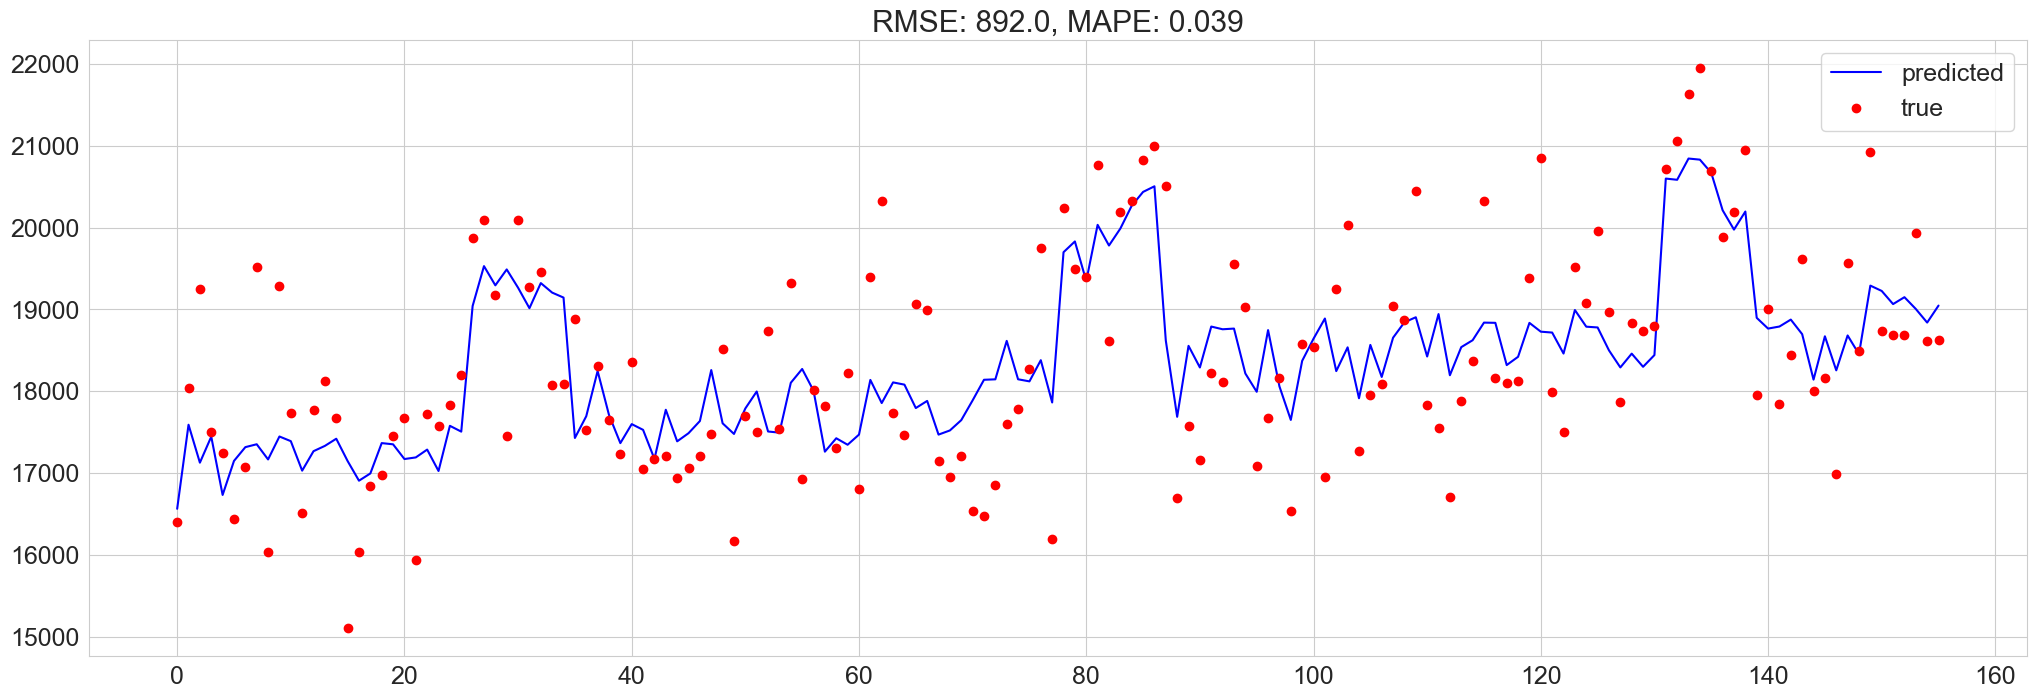

In [39]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])


print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')



fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}")
_ = ax.legend()

In [40]:
def format_thousands_millions(x, pos) -> str:
    if abs(x) >= 1e6:
        return "{:.1f}M".format(x * 1e-6)
    elif abs(x) >= 1e3:
        return "{:.1f}K".format(x * 1e-3)
    else:
        return "{:.1f}".format(x)
    
def plot_spend_response_curve(channel, spend_response_df, average_spend=0, average_response=0, optimized_spend=None, optimized_response=None, figure_size=(15, 6)):

    average_spend_response_df = pd.DataFrame({
        'average_spend': [average_spend], 
        'average_response': [average_response]
    })

    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    sns.scatterplot(data=average_spend_response_df, x='average_spend', y='average_response', color='blue', s=100)
    plt.axvline(x=average_spend_response_df['average_spend'][0], linestyle='dotted', alpha=0.5)
    plt.axhline(y=average_spend_response_df['average_response'][0], linestyle='dotted', alpha=0.5)

    #plt.xticks(ticks=range(0, int(max(spend_response_df["spend"])), 50_000)) 
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    
    
    
    if optimized_spend is not None and optimized_response is not None:
        optimized_spend_response_df = pd.DataFrame({
            'optimized_spend': [optimized_spend], 
            'optimized_response': [optimized_response]
        })
        sns.scatterplot(data=optimized_spend_response_df, x='optimized_spend', y='optimized_response', color='green', s=150)
        plt.axvline(x=optimized_spend_response_df['optimized_spend'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.axhline(y=optimized_spend_response_df['optimized_response'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.title(f"{channel}: Response curve, mean and optimized spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}\nOptimized Spend: {optimized_spend:.3f}\nOptimized Response: {optimized_response:.3f}")
    else:
        plt.title(f"{channel}: Response curve and mean spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}")

    plt.legend()
    plt.show()


def plot_multiple_spend_response_curves(spend_response_df, figure_size=(15, 6)):
    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response', hue='media_channel', style='media_channel')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    plt.title('Response curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
            
    plt.show()

In [41]:
feature_coefficients

{'Economic_Index': 115.1350345634046,
 'Vacances': 1788.8604088081674,
 'TV': 92.10327513009928,
 'Digital': 722.1680016186691,
 'OOH': 1053.4305583353369,
 'SEO': 153.74671410393927,
 'Social_Media': 587.096580370162}

### Generate Response Curves using Hill Saturation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TV
	TV: adstock: 0.6555938208687822
	TV: saturation slope: 2.9053396765145
	TV: half saturation k: 0.29933430759236856
	TV: coefficient: 92.10327513009928
	average spend: 9739, avergae non-zero spend: 9739, min spend: 5055.221171236024, max spend: 14868.869366005172
	average response corresponding to the average spending including weeks of no-spend: 14.332155741634908


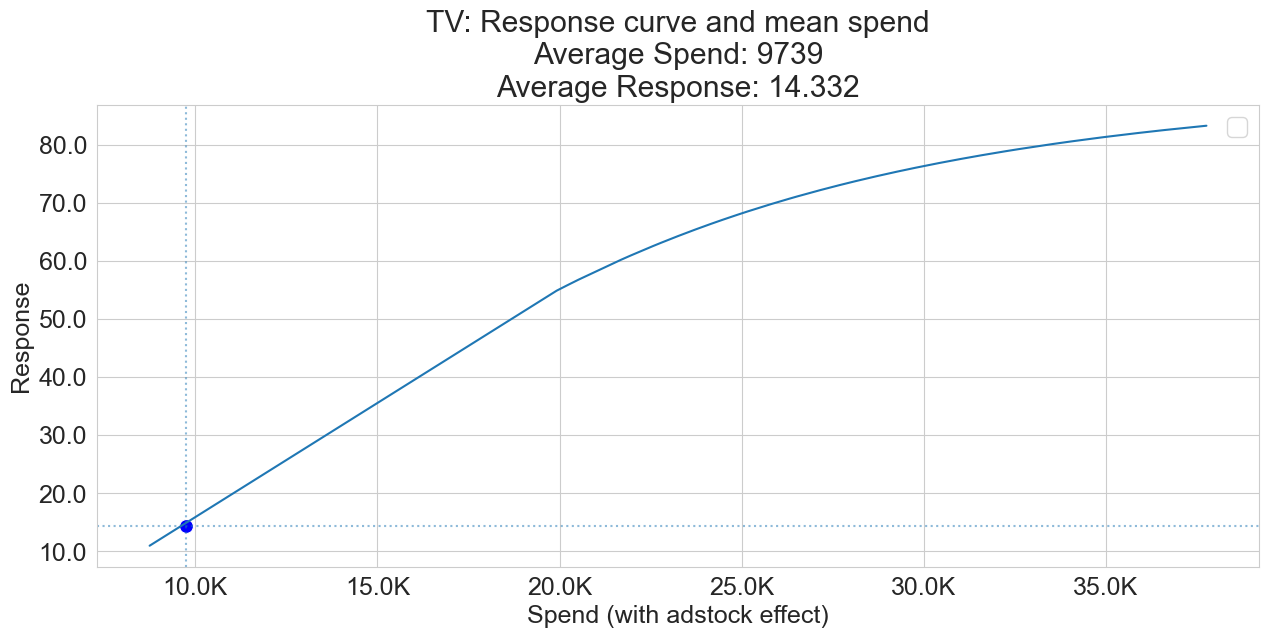

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
Digital
	Digital: adstock: 0.37146499334474115
	Digital: saturation slope: 4.749912161482324
	Digital: half saturation k: 0.5724567889158745
	Digital: coefficient: 722.1680016186691
	average spend: 6128, avergae non-zero spend: 6128, min spend: 2040.4926707697496, max spend: 9920.430800834107
	average response corresponding to the average spending including weeks of no-spend: 56.422341463689925


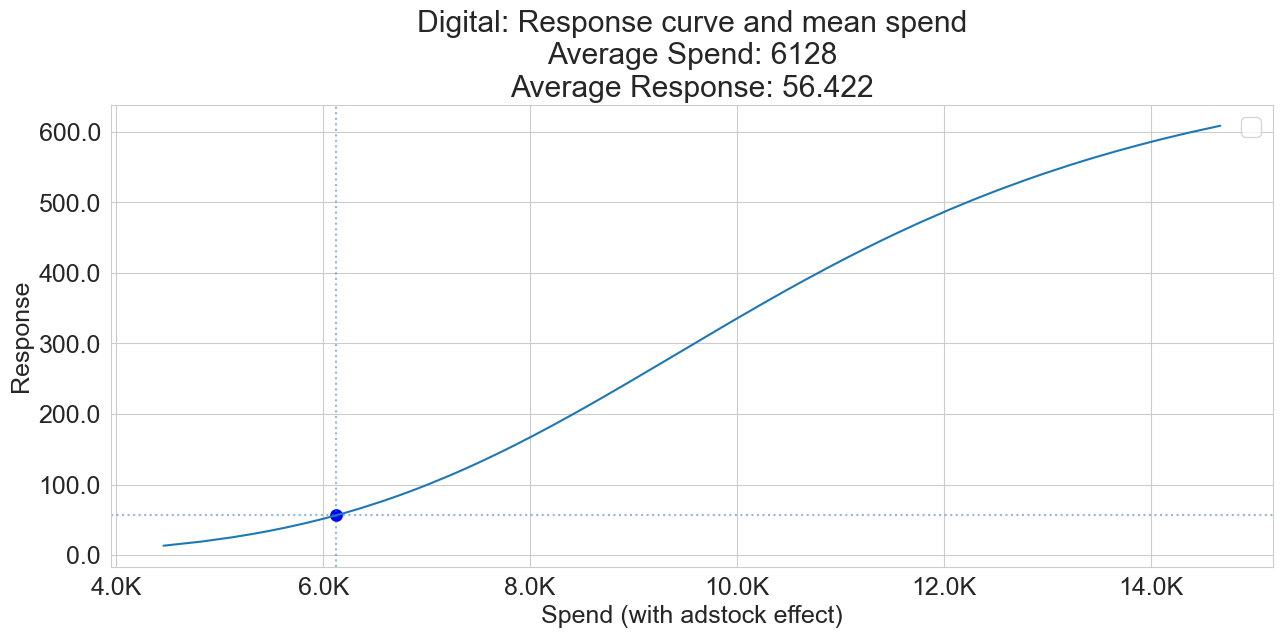

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
OOH
	OOH: adstock: 0.2088455969050809
	OOH: saturation slope: 1.3939241266439033
	OOH: half saturation k: 0.32668109483918095
	OOH: coefficient: 1053.4305583353369
	average spend: 4457, avergae non-zero spend: 4457, min spend: 1075.8635603620885, max spend: 7933.535994004713
	average response corresponding to the average spending including weeks of no-spend: 565.9701826341479


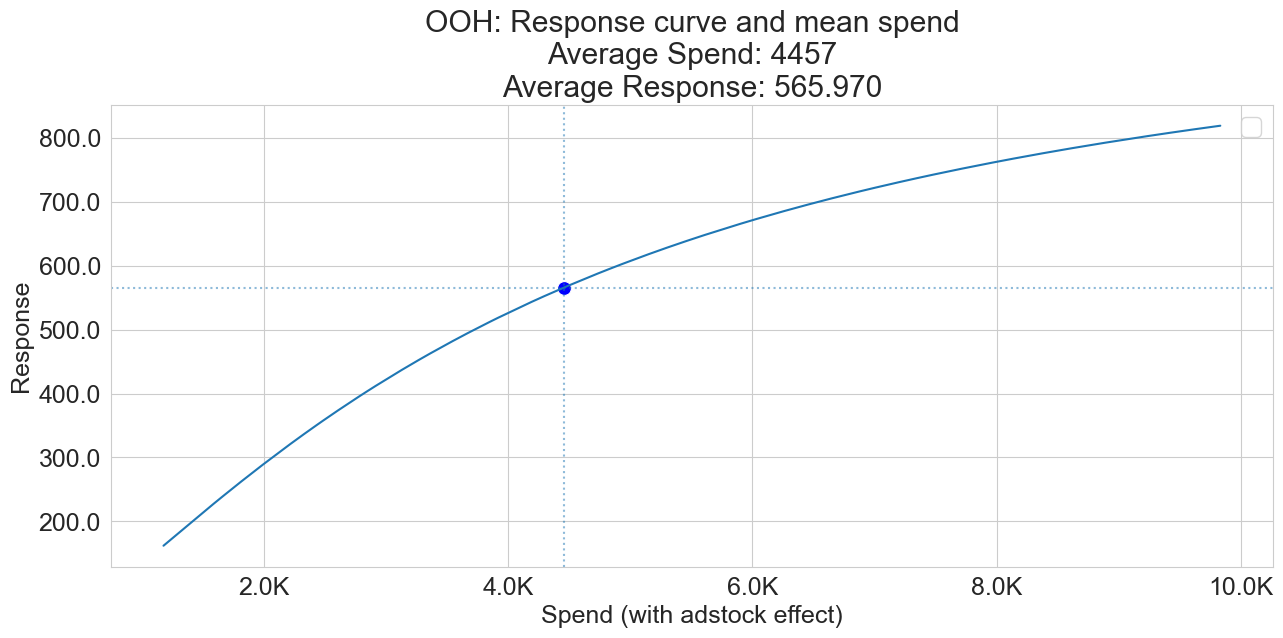

None


In [47]:
#dataframe for budget allocation
media_spend_response_data = []

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for media_channel in media_channels:
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_nonzero_spending)
    print(f"\taverage response corresponding to the average spending including weeks of no-spend: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
    
    plot = plot_spend_response_curve(media_channel, spend_response_temp_df, average_spend = average_nonzero_spending, average_response = average_response)
    print(plot)
    

media_spend_response_data = pd.concat(media_spend_response_data)

### Generate Response Curves as Partial Dependence

In [51]:
result["x_input_interval_transformed"].head()

,Economic_Index,Vacances,TV_hill,Digital_hill,OOH_hill,SEO_hill,Social_Media_hill
0,100.41343,0,0.11879,0.16982,0.15366,0.41720,0.58804
1,101.97680,0,0.60686,0.55928,0.72353,0.50506,0.42899
2,99.42621,0,0.75314,0.22332,0.74124,0.44576,0.51395
3,99.05535,0,0.79450,0.55238,0.71148,0.50893,0.75359
4,98.62128,0,0.73494,0.33790,0.60645,0.45205,0.10238


In [52]:
media_features = [f"{media_channel}_hill" for media_channel in media_channels]
media_features

['TV_hill', 'Digital_hill', 'OOH_hill']

In [53]:
temp_data = result["x_input_interval_transformed"].copy()
temp_data[media_features] = 0
zero_spend = result["model"].predict(temp_data).mean()
zero_spend

17366.46879485869

In [54]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'TV': 0.6555938208687822,
 'Digital': 0.37146499334474115,
 'OOH': 0.2088455969050809,
 'SEO': 0.3085060762637491,
 'Social_Media': 0.11405006570281054}

In [68]:
media_spend_response_data.groupby("media_channel").mean().reset_index()

,media_channel,spend,response
0,Digital,9728.17383,310.58658
1,OOH,5620.54471,610.64086
2,TV,27937.12948,72.16970


In [62]:
media_spend_response_partial_dependence = []

for media_feature, media_channel in zip(media_features, media_channels):
    print(f"feature: {media_feature}, channel: {media_channel}")
    other_media_features = list(set(media_features) - {media_feature})
    
    print(f"other_media_features: {other_media_features}")
    adstock_hill_spend = result["x_input_interval_transformed"][media_feature].values
    
    adstock_alpha = experiment.best_trial.user_attrs['adstock_alphas'][media_channel]
    print(f"adstock alpha: {adstock_alpha}")
    
    #copy the dataframe to avoid changing the original dataframe
    temp_data = result["x_input_interval_transformed"].copy()
    temp_data[other_media_features] = 0
    
    original_spend = result["x_input_interval_nontransformed"][media_channel]
    adstock_spend = AdstockGeometric(alpha = adstock_alpha).fit_transform(original_spend)
    
    
    media_response_channel = []
    for spend in adstock_hill_spend:
        temp_data[media_feature] = spend
        
        mean_response = result["model"].predict(temp_data).mean() - zero_spend
        media_response_channel.append(mean_response)
    
    media_response_channel = pd.DataFrame({"spend": adstock_spend, "response": media_response_channel, "media_channel": media_channel})
    media_spend_response_partial_dependence.append(media_response_channel)

media_spend_response_partial_dependence = pd.concat(media_spend_response_partial_dependence).reset_index(drop=True)

feature: TV_hill, channel: TV
other_media_features: ['OOH_hill', 'Digital_hill']
adstock alpha: 0.6555938208687822
feature: Digital_hill, channel: Digital
other_media_features: ['OOH_hill', 'TV_hill']
adstock alpha: 0.37146499334474115
feature: OOH_hill, channel: OOH
other_media_features: ['Digital_hill', 'TV_hill']
adstock alpha: 0.2088455969050809


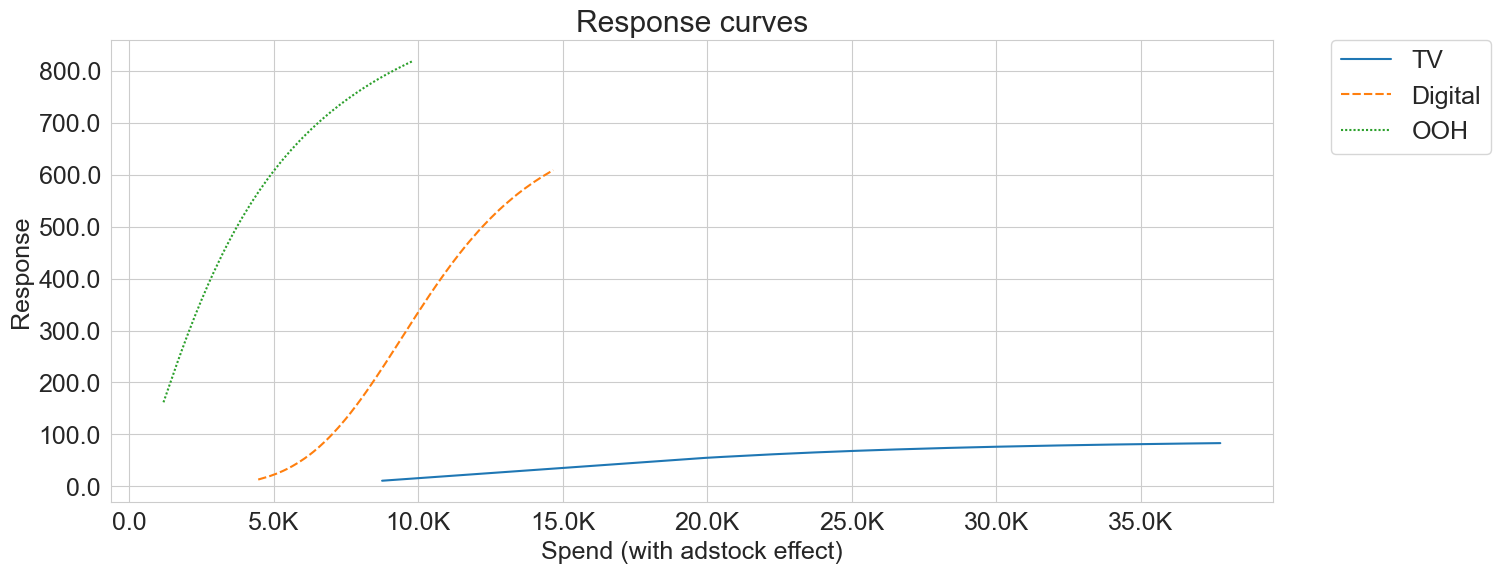

In [58]:
plot_multiple_spend_response_curves(media_spend_response_partial_dependence)

## Modeling ML (Lightgbm)

### Helper functions

In [84]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def shap_feature_importance(shap_values, data, figsize = (20, 10)):
    
    feature_list = data.columns

    if not isinstance(shap_values, pd.DataFrame):
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values


    df_v = data.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = []
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
def plot_shap_vs_spend(df_shap_values, 
                       x_input_interval_nontransformed, 
                       x_input_interval_transformed, 
                       features, 
                       media_channels, 
                       figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        
        ax.xaxis.set_major_formatter(
            mtick.FuncFormatter(format_thousands_millions)
        )
        
        plt.legend()
        
def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars=["media"], value_vars=["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill="variable")) \
    + geom_bar(stat="identity", position="dodge", alpha=0.5) \
    + geom_text(aes(label="value * 100", group="variable"), color="darkblue", position=position_dodge(width=0.5), format_string="{:.2f}%") \
    + coord_flip() \
    + ggtitle("Part des dépenses VS Part de l'effet") + ylab("") + xlab("") \
    + theme(figure_size=figure_size,
                legend_direction='vertical',
                legend_title=element_blank(),
                legend_key_size=20,
                legend_entry_spacing_y=5,
                panel_background=element_rect(fill="white"),
                panel_grid_major_y=element_blank(),
                panel_grid_minor_y=element_blank()) \
    + scale_fill_manual(values=["#09308E", "red"]) #"royalblue"

    return plt

def calculate_spend_effect_share(df_shap_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        df_shap_values: data frame of shap values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns: 
        [pd.DataFrame]: data frame with spend effect shares
    """
    responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
    response_percentages = responses / responses.sum()
    response_percentages

    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
    spends_percentages

    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})
    
    return spend_effect_share
    
def model_ml_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[:end_index][features].copy()
    y_true_all = data[target].values[:end_index]

    model = lgb.LGBMRegressor(**best_params, verbose=-1)
    model.fit(x_input, y_true_all)

    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)}")
    prediction = model.predict(x_input_interval_transformed)

    #transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    #shap explainer 
    explainer = shap.TreeExplainer(model)

    # get SHAP values for the data set for the analysis interval from explainer model
    shap_values_train = explainer.shap_values(x_input_interval_transformed)

    # create a dataframe of the shap values for the training set and the test set
    df_shap_values = pd.DataFrame(shap_values_train, columns=features)

    return {
            'df_shap_values': df_shap_values, 
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval, 
            "model": model
           }

In [85]:
def optuna_ml_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 media_features, 
                 is_monotone, 
                 is_random_forest,
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}

    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha

        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_temp[feature] = temp_adstock



    boosting_type = "rf" if is_random_forest else "gbdt"
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    subsample_freq = 1
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)




    #find indices of media channels for the monotonic constraint parameter
    monotone_constraints = np.zeros((len(features), ))
    for media_feature in media_features:
        if is_monotone:
            ind = features.index(media_feature)
            monotone_constraints[ind] = 1
    ###keep scores
    scores = []


    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]

        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]

    
        params = {
            "boosting_type" : boosting_type,
            "n_estimators"  : n_estimators,
            "subsample"     : subsample,
            "subsample_freq": subsample_freq,
            "colsample_bytree": colsample_bytree,
            "monotone_constraints": ",".join(str(ind) for ind in monotone_constraints)
        }

        model = lgb.LGBMRegressor(**best_params, verbose=-1)
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)

        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)


    trial.set_user_attr("scores", scores)

    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)


    return np.mean(scores)

In [77]:
def optuna_ml_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    media_features, 
                    is_monotone,
                    is_random_forest,
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_ml_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    media_features = media_features, 
                                    is_monotone = is_monotone,
                                    is_random_forest = is_random_forest,
                                    tscv = tscv)
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

In [86]:

tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

adstock_features_params = {
    "Spend_PO_adstock": (0.3, 0.8),
    "TV_adstock": (0.3, 0.8),
    "Digital_adstock": (0.1, 0.4),
    "OOH_adstock": (0.2, 0.5),
    "SEO_adstock": (0.1, 0.4),
    "Social_Media_adstock": (0.1, 0.4)
}

OPTUNA_TRIALS = 2000

IS_MONOTONE = True
IS_RANDOM_FOREST = False

experiment_ml = optuna_ml_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             is_monotone = IS_MONOTONE,
                             is_random_forest=IS_RANDOM_FOREST,
                             tscv = tscv)

data size: 156
media features: ['TV', 'Digital', 'OOH']
adstock features: ['TV', 'Digital', 'OOH', 'SEO', 'Social_Media']
features: ['Economic_Index', 'Vacances', 'TV', 'Digital', 'OOH', 'SEO', 'Social_Media']


C:\Users\Bens\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/2000 [00:00<?, ?it/s]

### Model Refit

In [87]:
best_params = experiment_ml.best_trial.user_attrs["params"]
best_params

{'boosting_type': 'gbdt',
 'n_estimators': 336,
 'subsample': 0.29508464594249306,
 'subsample_freq': 1,
 'colsample_bytree': 0.7413932973453888,
 'monotone_constraints': '0.0,0.0,1.0,1.0,1.0,0.0,0.0'}

In [88]:
adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"]
adstock_params

{'TV': 0.620542194541933,
 'Digital': 0.3969850146388821,
 'OOH': 0.2362537727190475,
 'SEO': 0.3736174669801124,
 'Social_Media': 0.21886190741680098}

In [89]:
best_params = experiment_ml.best_trial.user_attrs["params"]
adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"]
result_ml = model_ml_refit(data = data, 
                            target = target,
                            features = features, 
                            media_channels = media_channels, 
                            organic_channels = organic_channels, 
                            model_params = best_params, 
                            adstock_params = adstock_params, 
                            start_index = 0, 
                            end_index = data.shape[0])

applying geometric adstock transformation on TV with alpha 0.620542194541933
applying geometric adstock transformation on Digital with alpha 0.3969850146388821
applying geometric adstock transformation on OOH with alpha 0.2362537727190475
applying geometric adstock transformation on SEO with alpha 0.3736174669801124
applying geometric adstock transformation on Social_Media with alpha 0.21886190741680098
predicting 156


### Metrics

RMSE: 1071.6607429977178
MAPE: 0.0471795536636971


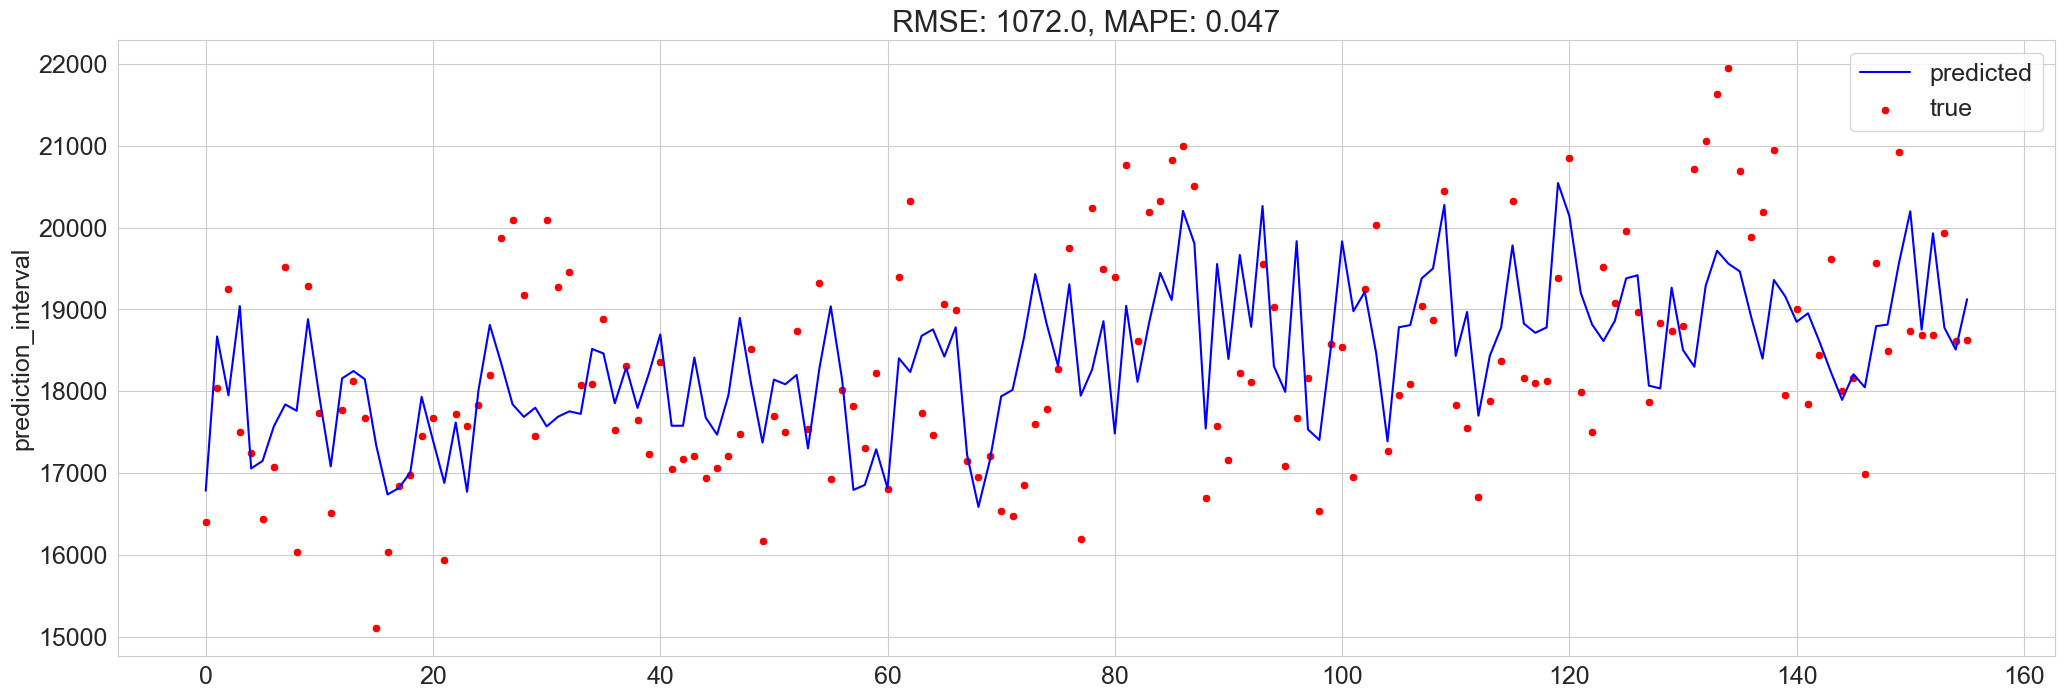

In [90]:
rmse_metric = mean_squared_error(y_true = result_ml["y_true_interval"], y_pred = result_ml["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result_ml["y_true_interval"], y_pred = result_ml["prediction_interval"])


print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')



fig, ax = plt.subplots(figsize=(25, 8))
sns.lineplot(data=result_ml, x = range(len(result_ml["prediction_interval"])), y='prediction_interval', color='blue', label='predicted', ax=ax)
sns.scatterplot(data=result_ml, x=range(len(result_ml["y_true_interval"])), y='y_true_interval', color='red', marker='o', label='true', ax=ax)
plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}")
_ = plt.legend()


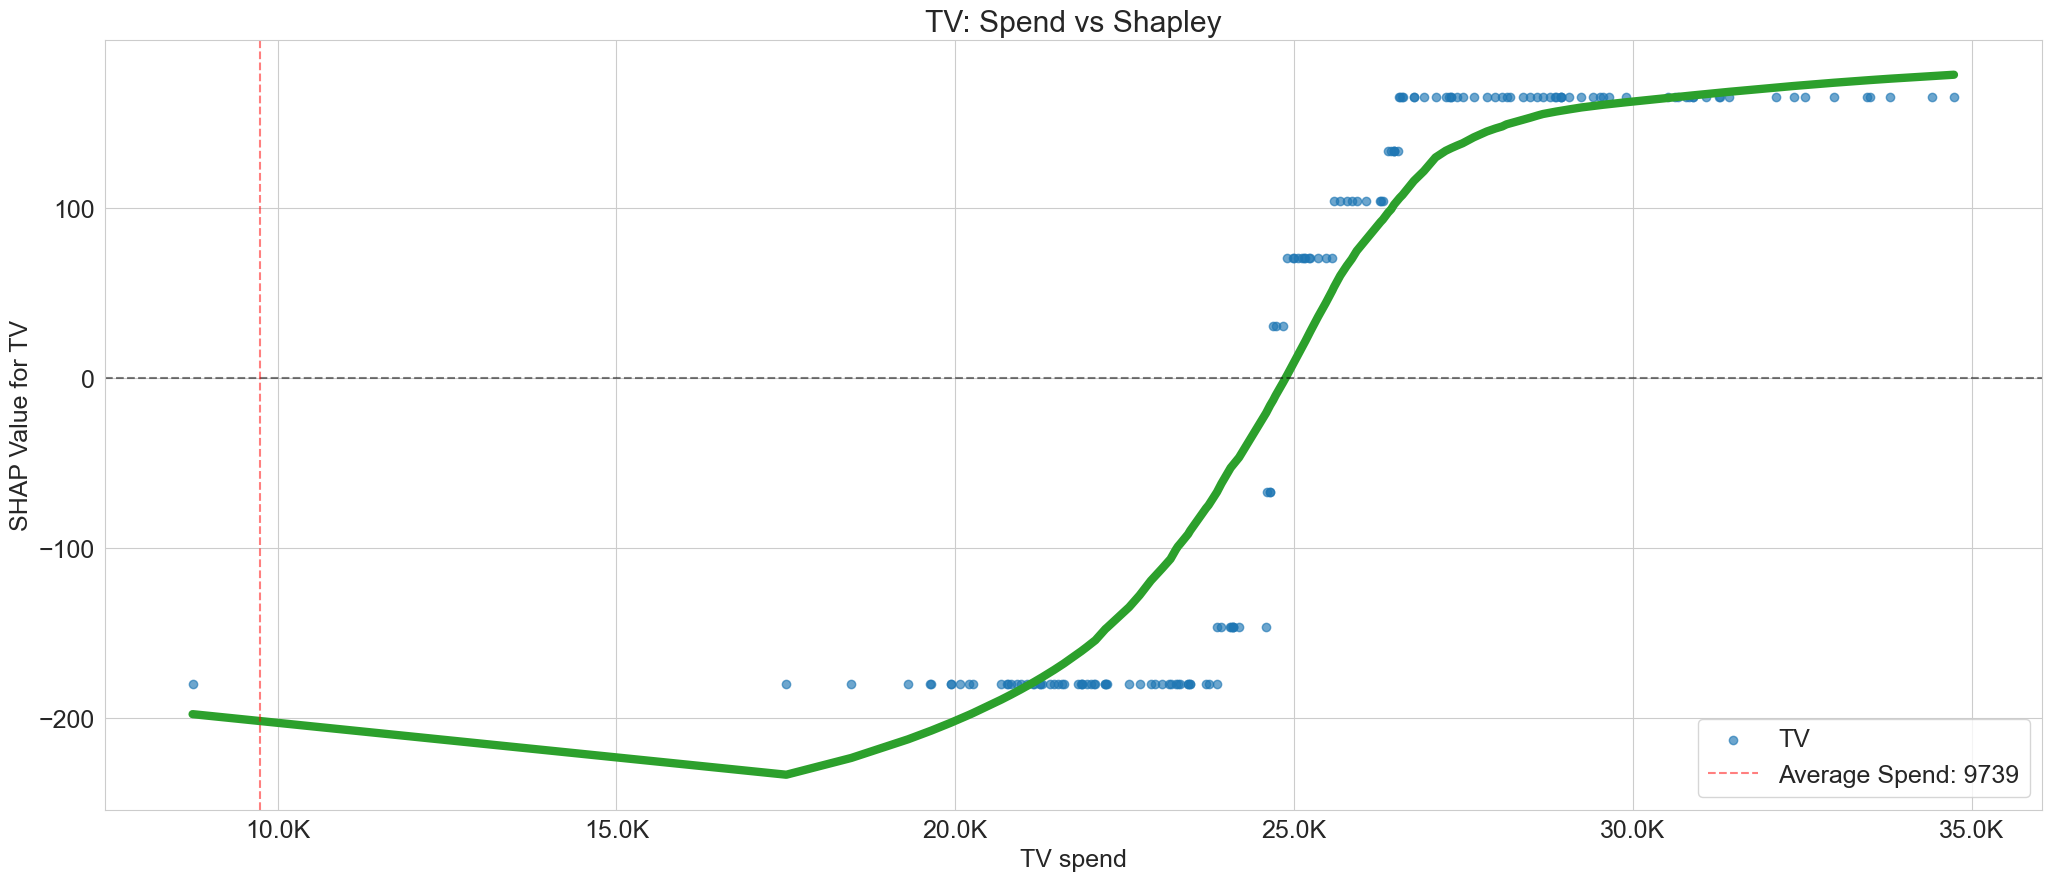

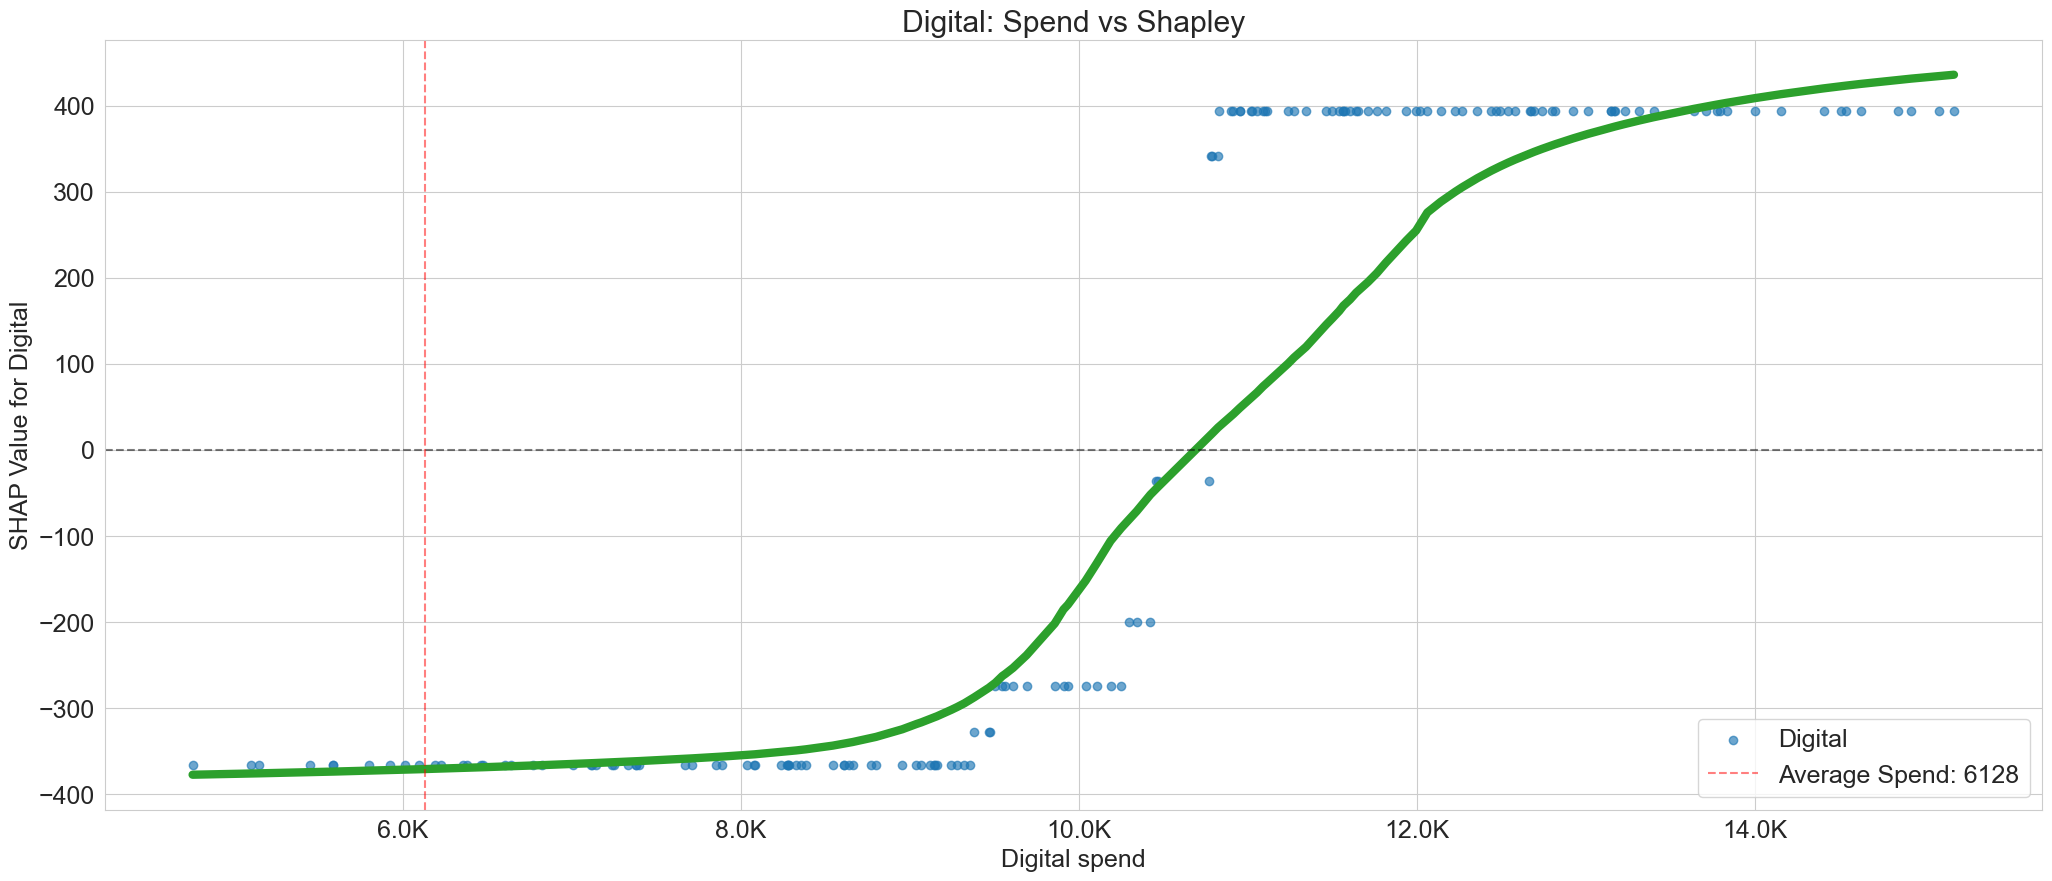

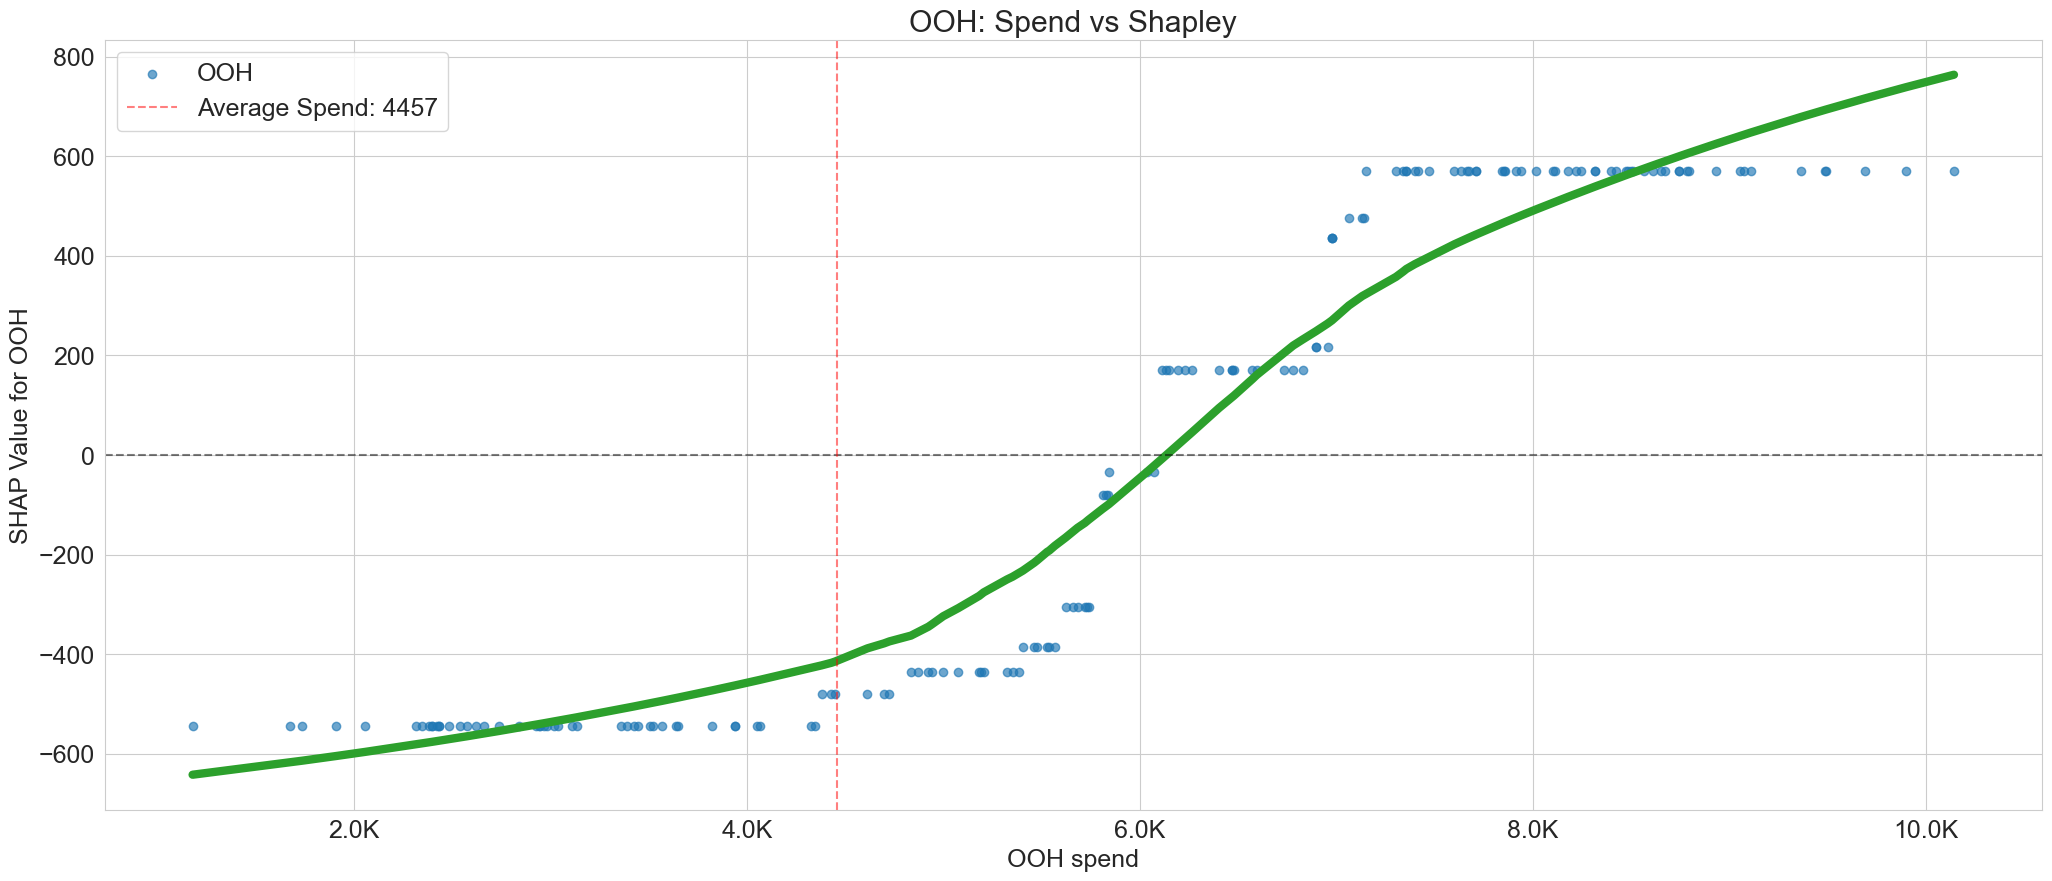

In [91]:
plot_shap_vs_spend(result_ml["df_shap_values"], 
                   result_ml["x_input_interval_nontransformed"], 
                   result_ml["x_input_interval_transformed"], 
                   features, 
                   media_channels)

### Generate Response Curves as Partial Dependence

In [92]:
result_ml["x_input_interval_nontransformed"].head()

,Date,TV,Digital,OOH,SEO,Social_Media,Economic_Index,Vacances,Revenu,trend,weekly
0,2022-01-02,8745.40119,7377.08438,1177.45520,1058.98960,3473.01909,100.41343,0,16408.75860,16646.17234,753.73045
1,2022-01-09,14507.14306,8092.95692,7738.53890,2908.05635,2475.65456,101.97680,0,18039.45786,16658.55084,753.73045
2,2022-01-16,12319.93942,3901.10035,6851.86084,530.38619,2850.13886,99.42621,0,19247.96652,16670.92934,753.73045
3,2022-01-23,10986.58484,7825.73079,5871.81944,2924.69707,3989.88375,99.05535,0,17500.95351,16683.30784,753.73045
4,2022-01-30,6560.18640,4942.26506,3862.67061,607.89978,1146.73281,98.62128,0,17243.10712,16695.68634,753.73045


In [93]:
result_ml["x_input_interval_transformed"].head()

,Economic_Index,Vacances,TV,Digital,OOH,SEO,Social_Media
0,100.41343,0,8745.40119,7377.08438,1177.45520,1058.98960,3473.01909
1,101.97680,0,19934.03351,11021.54887,8016.71714,3303.71336,3235.76614
2,99.42621,0,24689.84832,8276.49009,8745.84051,1764.71120,3558.32481
3,99.05535,0,26307.67750,11111.37333,7938.05726,3584.02400,4768.66551
4,98.62128,0,22885.21033,9353.31377,5738.06659,1946.95375,2190.41204


In [94]:
temp_data = result_ml["x_input_interval_transformed"].copy()
temp_data[media_channels] = 0
zero_spend = result_ml["model"].predict(temp_data).mean()
zero_spend

17322.233295433918

In [95]:
media_spend_response_partial_dependence_ml = []

for media_channel in media_channels:
    print(f"channel: {media_channel}")
    other_media_features = list(set(media_channels) - {media_channel})
    
    print(f"other_media_features: {other_media_features}")
    adstock_transformed_spend = result_ml["x_input_interval_transformed"][media_channel].values
    
    adstock_alpha = adstock_params = experiment_ml.best_trial.user_attrs["adstock_alphas"][media_channel]
    print(f"adstock alpha: {adstock_alpha}")
    
    #copy the dataframe to avoid changing the original dataframe
    temp_data = result_ml["x_input_interval_transformed"].copy()
    temp_data[other_media_features] = 0
    
    original_spend = result_ml["x_input_interval_nontransformed"][media_channel]
    adstock_spend = AdstockGeometric(alpha = adstock_alpha).fit_transform(original_spend)
    
    
    media_response_channel = []
    for spend in adstock_transformed_spend:
        temp_data[media_channel] = spend
        
        mean_response = result_ml["model"].predict(temp_data).mean() - zero_spend
        media_response_channel.append(mean_response)
    
    media_response_channel = pd.DataFrame({"spend": adstock_spend, "response": media_response_channel, "media_channel": media_channel})
    media_spend_response_partial_dependence_ml.append(media_response_channel)

media_spend_response_partial_dependence_ml = pd.concat(media_spend_response_partial_dependence_ml).reset_index(drop=True)

channel: TV
other_media_features: ['Digital', 'OOH']
adstock alpha: 0.620542194541933
channel: Digital
other_media_features: ['TV', 'OOH']
adstock alpha: 0.3969850146388821
channel: OOH
other_media_features: ['TV', 'Digital']
adstock alpha: 0.2362537727190475


In [96]:
media_spend_response_partial_dependence_ml

,spend,response,media_channel
0,8745.40119,0.00000,TV
1,19934.03351,0.00000,TV
2,24689.84832,210.64102,TV
3,26307.67750,283.82669,TV
4,22885.21033,0.00000,TV
...,...,...,...
463,6894.70446,762.65821,OOH
464,9364.10778,1115.14281,OOH
465,5836.39985,464.14907,OOH
466,4378.85609,65.83750,OOH


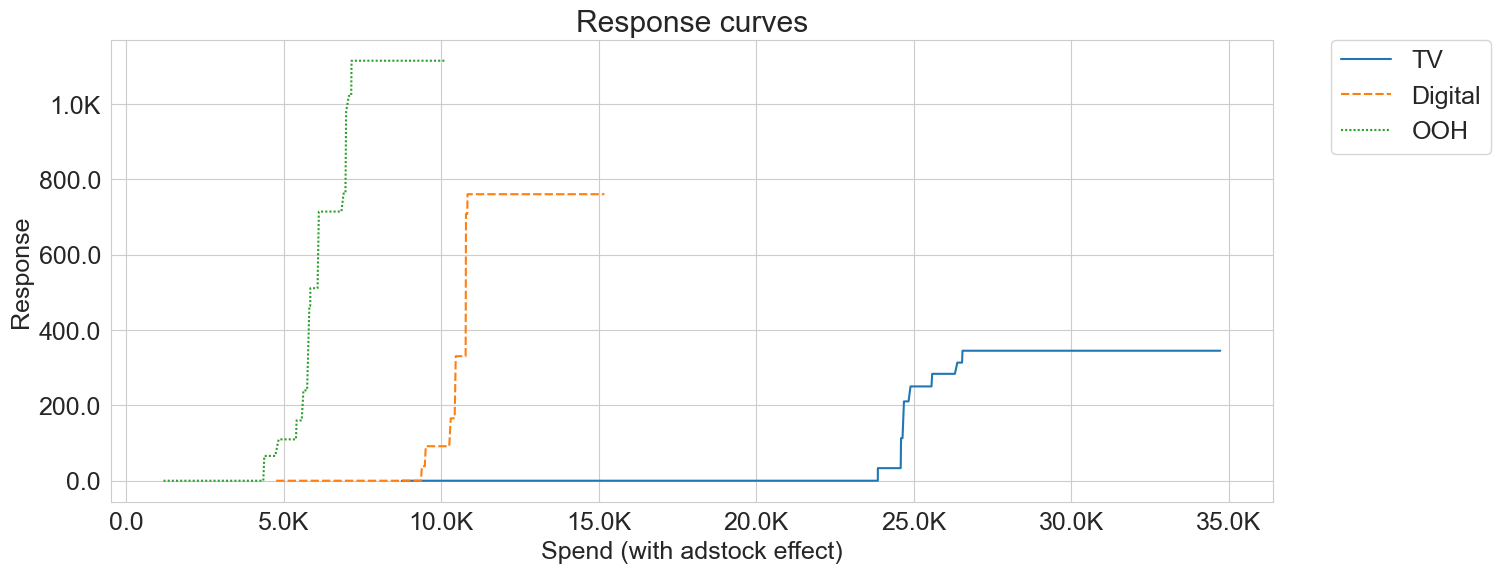

In [97]:
plot_multiple_spend_response_curves(media_spend_response_partial_dependence_ml)

In [98]:
media_spend_response_partial_dependence_ml

,spend,response,media_channel
0,8745.40119,0.00000,TV
1,19934.03351,0.00000,TV
2,24689.84832,210.64102,TV
3,26307.67750,283.82669,TV
4,22885.21033,0.00000,TV
...,...,...,...
463,6894.70446,762.65821,OOH
464,9364.10778,1115.14281,OOH
465,5836.39985,464.14907,OOH
466,4378.85609,65.83750,OOH


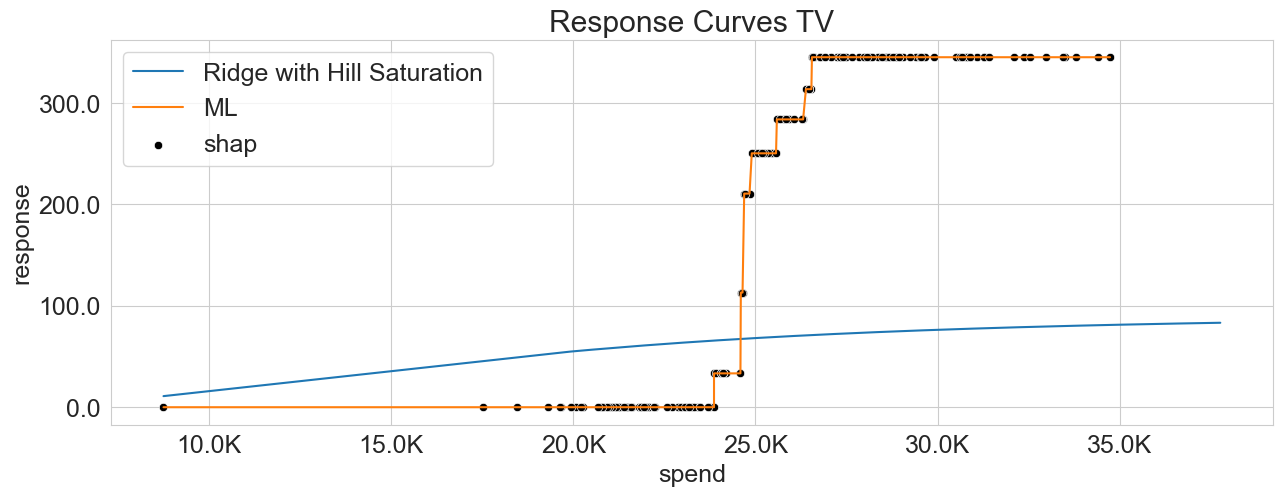

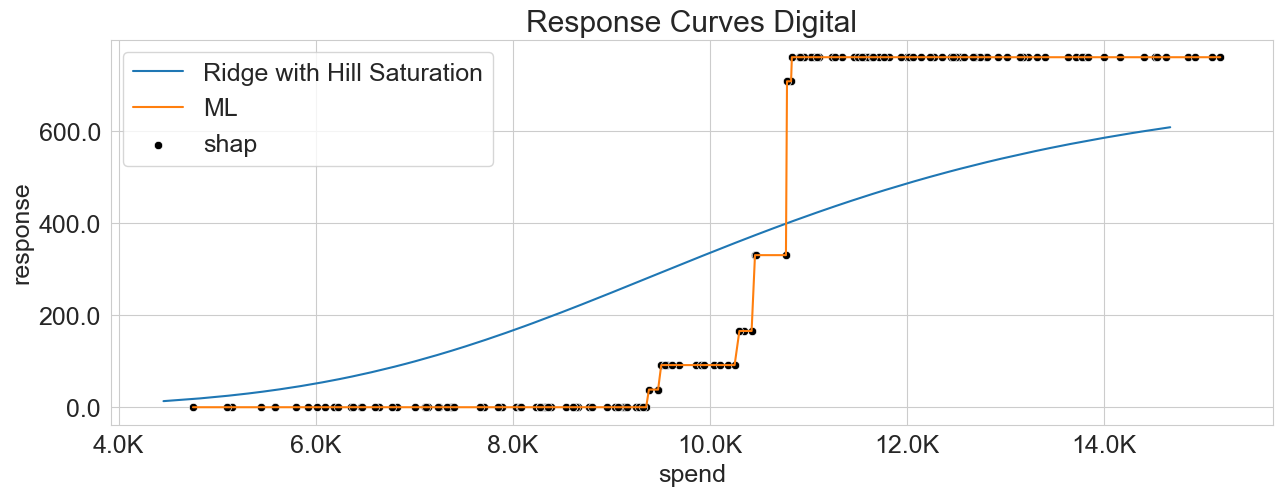

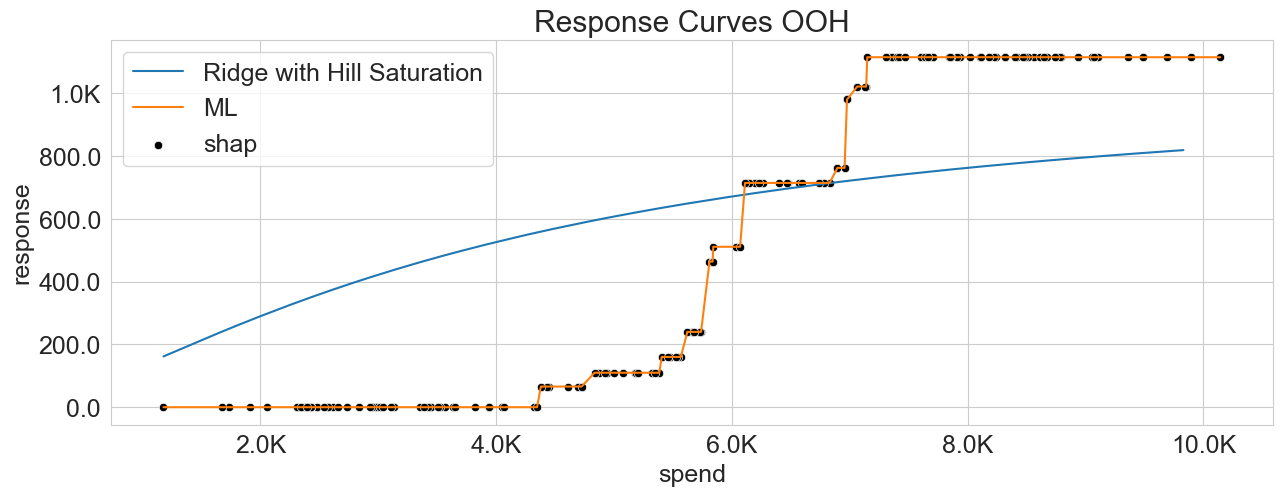

In [99]:
#difference between ml and ridge
for channel in media_channels:

    f, axs = plt.subplots(1, 1, figsize=(15, 5))


    channel_spend_adstock = result_ml["x_input_interval_transformed"][channel]
    channel_shap = result_ml["df_shap_values"][channel]


    chart = sns.lineplot(data = media_spend_response_partial_dependence.query("media_channel == @channel"), x = "spend", y = "response", label = "Ridge with Hill Saturation", ax = axs)
    sns.lineplot(data = media_spend_response_partial_dependence_ml.query("media_channel == @channel"), x = "spend", y = "response", label = "ML", ax = axs)
    sns.scatterplot(x = channel_spend_adstock, y = channel_shap + abs(channel_shap.min()), label = "shap", color = "black", ax = axs)
    axs.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    axs.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    chart.set_title(f"Response Curves {channel}")

C:\Users\Bens\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Bens\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning:

invalid value encountered in true_divide



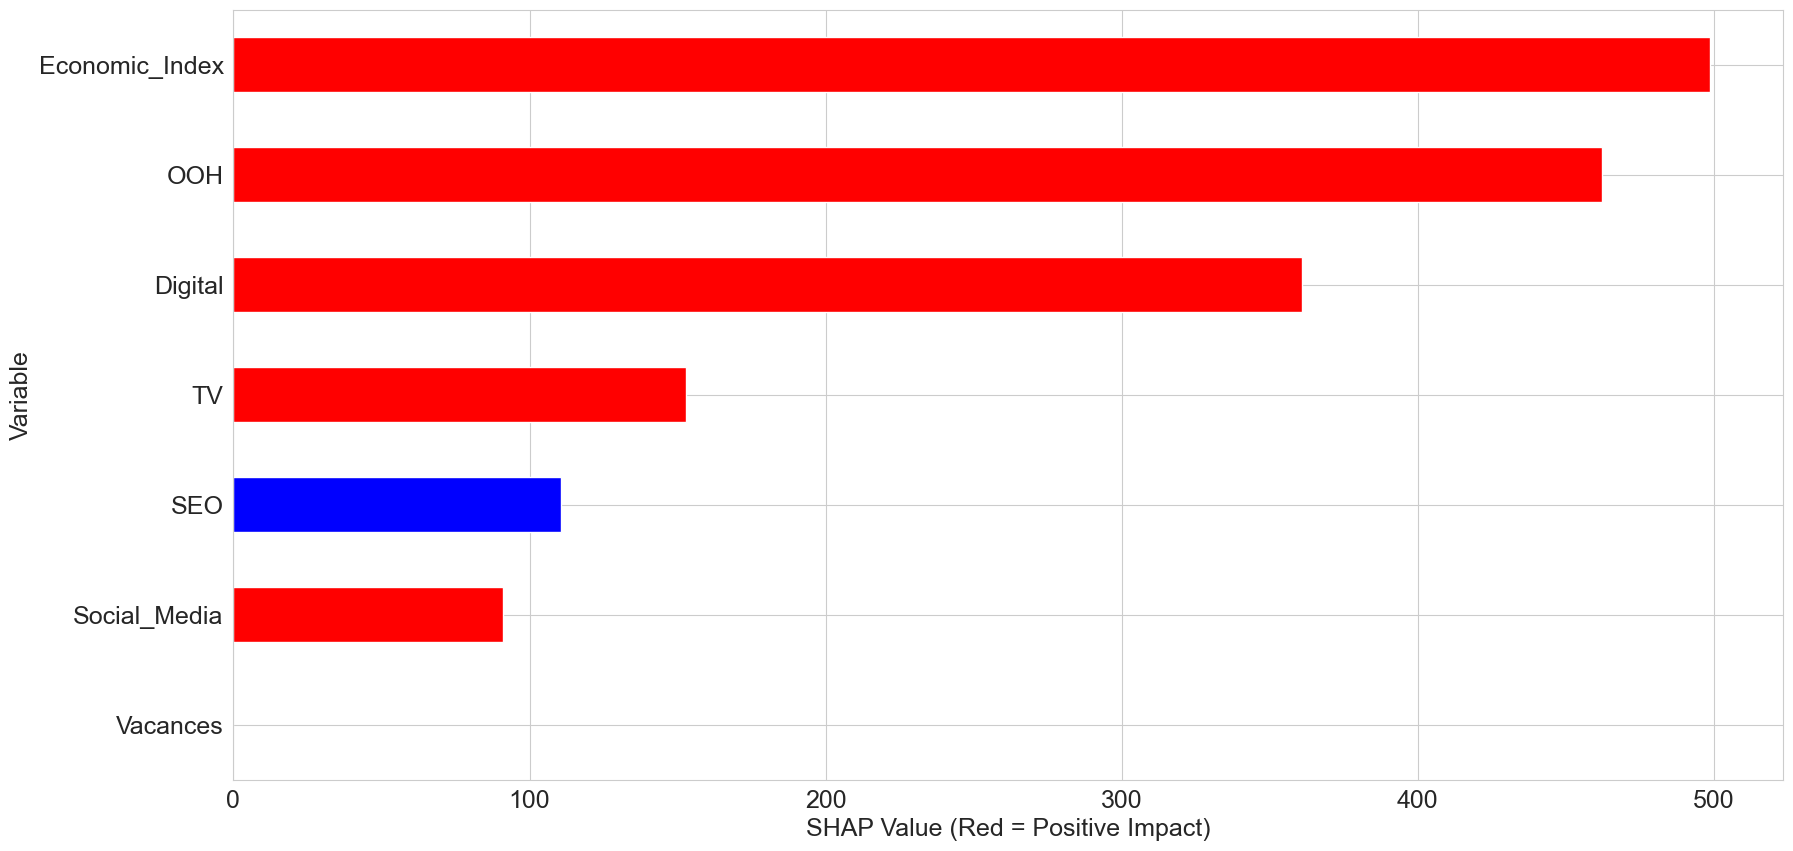

In [100]:
shap_feature_importance(result_ml["df_shap_values"], result_ml["x_input_interval_transformed"])

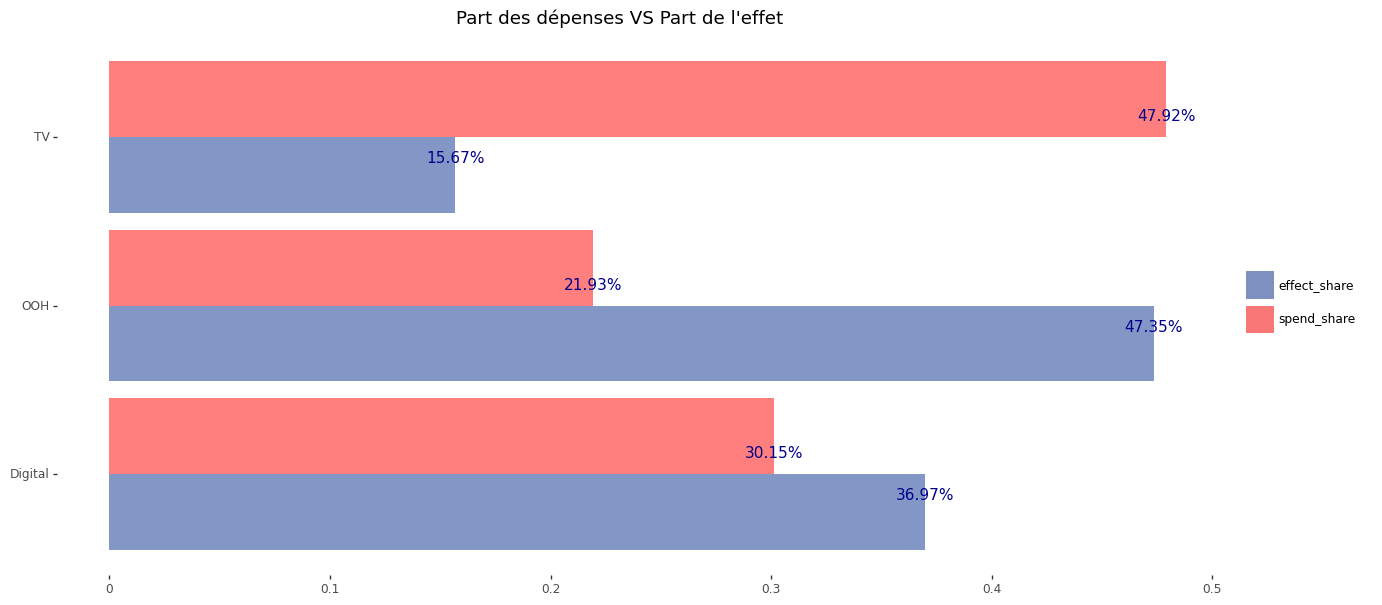

<ggplot: (179526197152)>

In [101]:
spend_effect_share = calculate_spend_effect_share(df_shap_values = result_ml["df_shap_values"], media_channels = media_channels, df_original = result_ml["x_input_interval_nontransformed"])
plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7))